In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 28.6 MB/s eta 0:00:00


In [1]:
# import py7zr
import os
import pandas as pd
import numpy as np
import codecs
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
input_file = '/content/dataSample.7z'
output_dir = '/content/sample_data/'

# Extract the 7zip file
with py7zr.SevenZipFile(input_file, mode='r') as z:
    z.extractall(path=output_dir)

print(f'Extracted {input_file} to {output_dir}')

Extracted /content/dataSample.7z to /content/sample_data/


In [ ]:
files = os.listdir(output_dir)
files

['README.md',
 'anscombe.json',
 '0A32eTdBKayjCWhZqDOQ.bytes',
 '0ACDbR5M3ZhBJajygTuf.asm',
 '0ACDbR5M3ZhBJajygTuf.bytes',
 '0A32eTdBKayjCWhZqDOQ.asm',
 'mnist_train_small.csv',
 'mnist_test.csv',
 'california_housing_train.csv',
 'california_housing_test.csv']

In [ ]:
bytes_files = [file for file in files if file.endswith('.bytes')]
asm_files = [file for file in files if file.endswith('.asm')]
print('bytes files: ', bytes_files)
print('asm files: ', asm_files)

bytes files:  ['0A32eTdBKayjCWhZqDOQ.bytes', '0ACDbR5M3ZhBJajygTuf.bytes']
asm files:  ['0ACDbR5M3ZhBJajygTuf.asm', '0A32eTdBKayjCWhZqDOQ.asm']


In [ ]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
opcodes_dict = dict(zip(opcodes, [1 for i in range(len(opcodes))]))

In [ ]:
def n_gram_counter(path, N = 1):
  feature_dict = dict()

  if path.endswith('.bytes'):
    with open(output_dir + path, 'r') as fp:
      for line in fp:
        row =line.rstrip().split(" ")[1:]
        for i in range(len(row)-1):
          n_grams = ','.join(row[i:N+i])
          if n_grams not in feature_dict:
            feature_dict[n_grams] = 1
          else:
            feature_dict[n_grams] += 1
    fp.close()

  if path.endswith('asm'):
    with codecs.open(output_dir + path, encoding='cp1252',errors ='replace') as fli:
      filtered_opcodes = []
      for line in fli:
        line=line.rstrip().split(" ")[1:]
        row = [element for element in line if opcodes_dict.get(element) == 1]
        filtered_opcodes.extend(row)

      for i in range(len(filtered_opcodes)-1):
          n_grams = ','.join(filtered_opcodes[i:N+i])
          if n_grams not in feature_dict:
            feature_dict[n_grams] = 1
          else:
            feature_dict[n_grams] += 1
    fli.close()

  output = dict(sorted(feature_dict.items()))
  output['ID'] = path.split('.')[0]
  return output

# Bytes Files N-Grams

In [ ]:
%%time
for n in range(1, 3):
  args = [(file, n) for file in bytes_files]
  with ThreadPoolExecutor() as executor:
    results = list(executor.map(n_gram_counter, *zip(*args)))
  bytes_features_df = pd.DataFrame(results)
  features_without_id = [feature for feature in bytes_features_df.keys() if feature != "ID"]
  bytes_features_df = bytes_features_df[['ID']+features_without_id]
  bytes_features_df.to_csv(f"bytes_features_{n}_grams.csv", index=False)

CPU times: user 3.19 s, sys: 67.5 ms, total: 3.26 s
Wall time: 3.25 s


In [ ]:
bytes_features_df

,ID,"00,00","00,01","00,02","00,03","00,04","00,05","00,06","00,07","00,08",...,"FE,42","FE,59","FE,67","FE,87","FE,93","FE,9F","FE,A3","FE,BB","FE,D4","FE,E3"
0,0A32eTdBKayjCWhZqDOQ,29667,775,535,350,272,124,146,152.0,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0ACDbR5M3ZhBJajygTuf,7030,1756,1471,2,1685,1,1553,NaN,1639,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
len(bytes_features_df.columns)

258

In [ ]:
# bytes_features_df.to_csv("bytes_features.csv")

In [ ]:
# byte_features_with_size = byte_features.merge(data_size_byte, on='ID')
# byte_features_with_size.to_csv("result_with_size.csv")
# byte_features_with_size.head(2)

In [ ]:
# def normalize(df):
#     result1 = df.copy()
#     for feature_name in df.columns:
#         if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
#             max_value = df[feature_name].max()
#             min_value = df[feature_name].min()
#             result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result1

# result = normalize(byte_features_with_size)

19

# ASM File N-grams

In [ ]:
%%time
for n in range(1, 2):
  args = [(file, n) for file in asm_files]
  with ThreadPoolExecutor() as executor:
    results = list(executor.map(n_gram_counter, *zip(*args)))
  asm_features_df = pd.DataFrame(results)
  asm_features_df = asm_features_df[['ID']+list(asm_features_df.keys())[:-1]]
  # asm_features_df = asm_features_df.fillna(0)
  asm_features_df.to_csv(f"asm_features_{n}_grams.csv", index=False)

CPU times: user 7.94 s, sys: 127 ms, total: 8.07 s
Wall time: 8.29 s


In [ ]:
asm_features_df.columns[asm_features_df.isna().sum() >0]

Index(['imul', 'jnb', 'movzx', 'nop', 'shl'], dtype='object')

In [ ]:
asm_features_df.columns

Index(['ID', 'add', 'call', 'cmp', 'dec', 'imul', 'inc', 'jmp', 'jnb', 'jz',
       'lea', 'mov', 'movzx', 'nop', 'or', 'pop', 'push', 'retn', 'shl', 'shr',
       'sub', 'xor'],
      dtype='object')

In [ ]:
len(asm_features_df.columns)

22

# Top 170 bytes 2-gram

In [15]:
bytes_2 = pd.read_csv('bytes_features_2_grams.csv')

In [16]:
null_count = bytes_2.isna().sum()

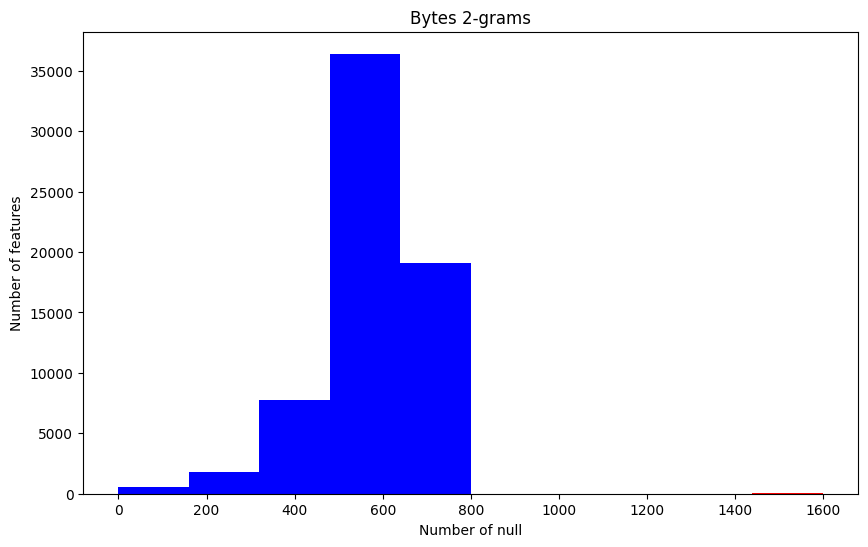

In [18]:
# Check the distribution of number of null values
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(list(null_count), bins=10, color='blue')
for i in range(len(patches)):
  if bins[i] >= len(bytes_2)*0.49:
    patches[i].set_facecolor('red')
plt.xlabel('Number of null')
plt.ylabel('Number of features')
plt.title('Bytes 2-grams')
plt.show()

In [ ]:
null_features_to_drop = bytes_2.columns[bytes_2.isna().sum() > len(bytes_2)*0.5]
null_features_to_drop

Index(['??,6C', '0F,??', '??,66', '??,80', '??,7A', '??,6A', '06,??', '??,74',
       '??,70', '??,72', '??,5E', '85,??', '22,??', '??,76', '04,??', '??,5A',
       'B7,??', '10,??', '??,7C', '??,7E', '??,A0', '??,60', 'EE,??', '??,6E',
       '??,68', '31,??', '??,9A', 'D5,??', '??,92', '??,8A', '??,5C', '42,??',
       '??,58', '01,??', '??,86', 'D9,??', '12,??', '3A,??', '6A,??', '??,B0',
       '??,FF', 'C5,??', '??,84', '??,94', '??,64', '??,88', '??,82', '96,??',
       '??,90', '??,78', '75,??', '7E,??', 'C8,??', '17,??', '36,??', 'D6,??',
       '??,8E', '03,??', '1C,??', '08,??', '2D,??', '9A,??', '55,??', '??,98'],
      dtype='object')

In [ ]:
bytes_2.drop(columns=null_features_to_drop, inplace=True)
bytes_2.fillna(0, inplace=True)

In [ ]:
# Extract top 170 bytes 2-grams using Chi-Square Test
labels_csv = pd.read_csv("trainLabels.csv")
bytes_2_with_labels = pd.merge(bytes_2, labels_csv, left_on="ID", right_on="Id", how="left")
labels = bytes_2_with_labels[["Class"]]
labels.head()

,Class
0,8
1,2
2,2
3,6
4,8


In [ ]:
%%time
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# SelectKBest scores the features using a function (chi2), and takes the top 170 features
select_kbest = SelectKBest(score_func=chi2, k=170)

most_imp_features_byte_bigram = select_kbest.fit(bytes_2.drop("ID", axis=1), labels)

# most_imp_features_byte_bigram.scores_ => gives an array of form
# array([9.79531407e+05, 4.26642398e+04, 1.78812060e+04, ..., 4.33426736e+07])
# So now creating a df from this array
most_imp_byte_bigram_feature_score_df = pd.DataFrame(most_imp_features_byte_bigram.scores_)

# Creating a df from all the column names from the original full bytes_2 df
features_without_id = [feature for feature in bytes_2.keys() if feature != "ID"]
most_imp_byte_bigram_columns_df = pd.DataFrame(features_without_id)

CPU times: user 2.56 s, sys: 385 ms, total: 2.95 s
Wall time: 4.56 s


In [ ]:
# Concat the feature scores along with the feature names in a byte_bigram_df_important_feature_score,
# From this we will get all feature names later, to be matched against bytes_2 - to extract ONLY the best features from the bigrams df data

byte_bigram_df_important_feature_score = pd.concat([most_imp_byte_bigram_columns_df, most_imp_byte_bigram_feature_score_df],axis=1)

byte_bigram_df_important_feature_score.columns = ["Byte Bigram Top 170 Feature Names","Byte Bigram Top 170 Feature Score"]

# Find the top 170 features along with their scores

# byte_bigram_df_important_feature_score=byte_bigram_df_important_feature_score.nlargest(1000, "Byte Bigram Top 170 Feature Score")

# Return the first 170 rows with the largest values in the specified column ( "Byte Bigram Top 170 Feature Score" )
# in descending order. The columns that are not specified are returned as well, but not used for ordering.
byte_bigram_df_important_feature_score = byte_bigram_df_important_feature_score.nlargest(170, "Byte Bigram Top 170 Feature Score")

byte_bigram_df_important_feature_score.head()

,Byte Bigram Top 170 Feature Names,Byte Bigram Top 170 Feature Score
23732,"??,??",1.312511e+09
29803,"CC,CC",3.564090e+07
0,"00,00",2.575357e+07
36837,"FF,FF",3.959423e+06
28832,"C5,C5",1.487025e+06


In [ ]:
# Getting the list of first 2000 feature names
top_170_most_imp_byte_bigram_feature_names = list(byte_bigram_df_important_feature_score["Byte Bigram Top 170 Feature Names"])

# top_170_byte_bigram_features = dd.concat([bytes_2["ID"], bytes_2[top_170_most_imp_byte_bigram]], axis=1)
top_170_byte_bigram_features = pd.concat([bytes_2["ID"], bytes_2[top_170_most_imp_byte_bigram_feature_names]], axis=1)

top_170_byte_bigram_features.to_csv("top_170_imp_byte_bigram_df.csv",index=None)

print(top_170_byte_bigram_features.shape)
top_170_byte_bigram_features.head(2)

(1600, 171)


,ID,"??,??","CC,CC","00,00","FF,FF","C5,C5","10,6B","25,25","10,94","10,62",...,"60,9F","74,74","60,4B","02,C8","55,55","CF,CF","06,1C","06,0E","FD,F7","37,37"
0,04hSzLv5s2TDYPlcgpHB,8025.0,12.0,20773.0,329.0,1.0,1.0,4.0,1.0,0.0,...,3.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0
1,05aiMRw13bYWqZ8OHvjl,12276.0,672.0,25141.0,6836.0,0.0,1.0,0.0,1.0,0.0,...,1.0,3.0,0.0,2.0,9.0,0.0,0.0,0.0,2.0,1.0


In [ ]:
bytes_1 = pd.read_csv('bytes_features_1_grams.csv')

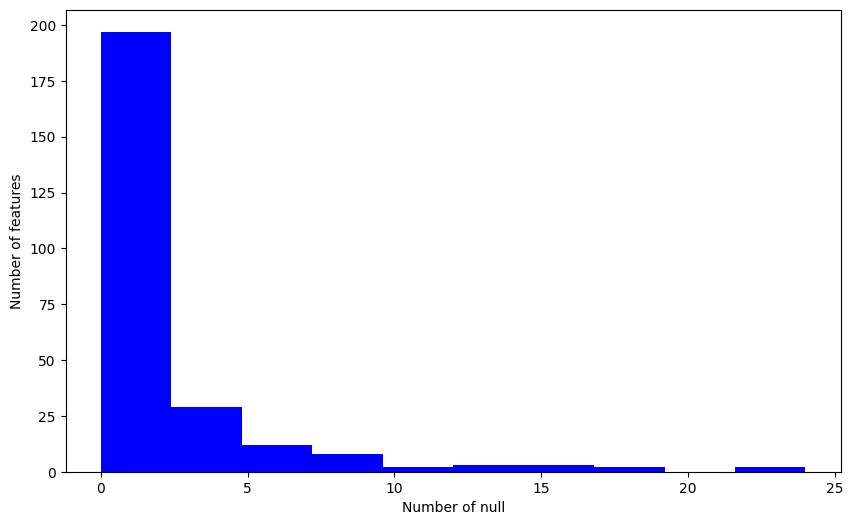

In [ ]:
# Check the distribution of number of null values
null_count_1 = bytes_1.isna().sum()
plt.figure(figsize=(10, 6))
plt.hist(list(null_count_1), bins=10, color='blue')
plt.xlabel('Number of null')
plt.ylabel('Number of features')
plt.show()

All features have less than 25 null values. Since we have 1600 rows, there's no need to drop any features as the null values may provide information about the malware.

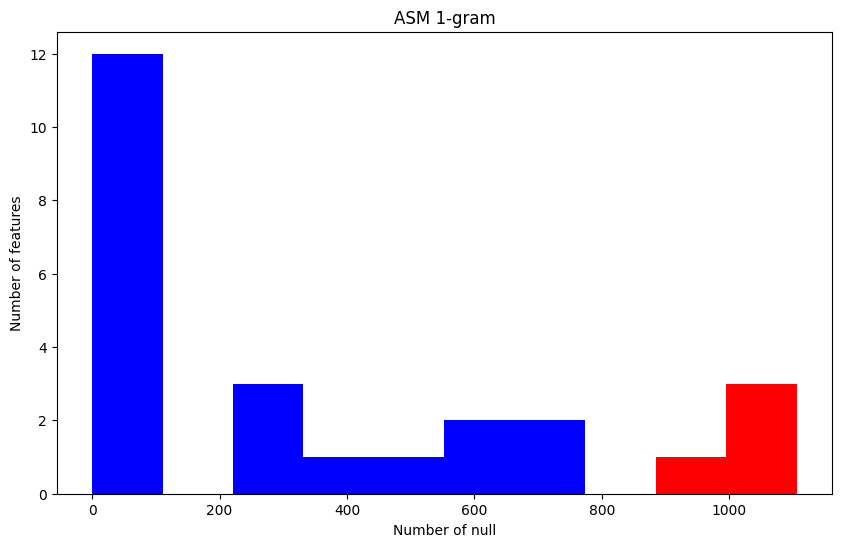

In [9]:
asm_1 = pd.read_csv('asm_features_1_grams.csv')
# Check the distribution of number of null values
null_count_1 = asm_1.apply(lambda feature: (feature == 0).sum())
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(list(null_count_1), bins=10, color='blue')
for i in range(len(patches)):
  if bins[i] >= len(asm_1)*0.5:
    patches[i].set_facecolor('red')
plt.xlabel('Number of null')
plt.ylabel('Number of features')
plt.title('ASM 1-gram')
plt.show()

In [ ]:
null_features_to_drop = asm_1.columns[asm_1.apply(lambda feature: (feature == 0).sum()) > len(asm_1)*0.5]
null_features_to_drop

Index(['retf', 'rol', 'ror', 'nop'], dtype='object')

In [ ]:
asm_1.drop(columns=null_features_to_drop, inplace=True)

In [ ]:
asm_1.to_csv("asm_features_1_gram_dropped.csv", index=False)

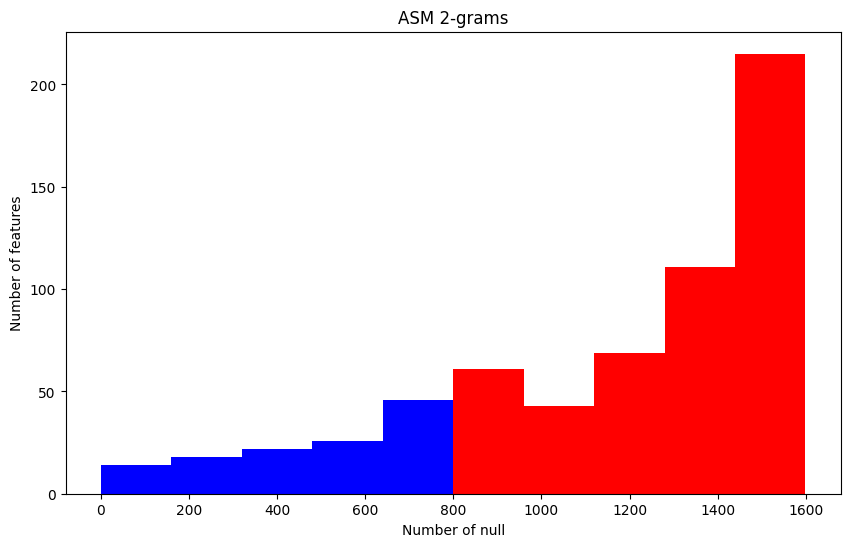

In [14]:
asm_2 = pd.read_csv('asm_features_2_grams.csv')
# Check the distribution of number of null values
null_count_2 = asm_2.apply(lambda feature: (feature == 0).sum())
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(list(null_count_2), bins=10, color='blue')
for i in range(len(patches)):
  if bins[i] >= len(asm_2)*0.49:
    patches[i].set_facecolor('red')
plt.xlabel('Number of null')
plt.ylabel('Number of features')
plt.title('ASM 2-grams')
plt.show()

In [ ]:
null_features_to_drop = asm_2.columns[asm_2.apply(lambda feature: (feature == 0).sum()) > len(asm_2)*0.5]
null_features_to_drop

Index(['add,dec', 'add,xchg', 'cmp,dec', 'cmp,movzx', 'cmp,or', 'cmp,retn',
       'cmp,xchg', 'dec,cmp', 'dec,inc', 'dec,push',
       ...
       'jnb,rol', 'movzx,nop', 'movzx,retf', 'jz,rol', 'jnb,ror', 'nop,jnb',
       'jz,ror', 'ror,movzx', 'shl,jnb', 'rol,jnb'],
      dtype='object', length=499)

In [ ]:
len(null_features_to_drop)

499

In [ ]:
asm_2.drop(columns=null_features_to_drop, inplace=True)

In [ ]:
asm_2.to_csv("asm_features_2_grams_dropped.csv", index=False)